In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pystan
import arviz as az

sns.set(style='whitegrid')

In [2]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
  
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    # Plotting
    ax1.plot(param)
    ax1.set(xlabel='samples', ylabel=param_name,
           title='Trace and Posterior Distribution for {}'.format(param_name)
           )
    ax1.axhline(mean, color='r', lw=2, linestyle='--')
    ax1.axhline(median, color='c', lw=2, linestyle='--')
    ax1.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax1.axhline(cred_max, linestyle=':', color='k', alpha=0.2)

    ax2.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax2)
    ax2.set(xlabel=param_name, ylabel='density')
    ax2.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax2.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax2.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
    ax2.axvline(cred_max, linestyle=':', color='k', alpha=0.3)

    fig.tight_layout()
    plt.legend()


In [3]:
df = (pd.read_excel('~/Dropbox/ROZ/data/Fontainebleau/Goudarzi et al. 2018.xlsx')
     .assign(Class=lambda x: x.Class.fillna(method='ffill'),
            porosity=lambda x: x.phi * 100)
     )
df.head()

Class  Sample  L (mm)  Dm (mm)     phi  k (mD)   tau_h   tau_e        F  \
0    A1       1  2.6571    0.176  0.1410   706.0  1.4747  1.2897  21.3457   
1    A1       2  2.6571    0.181  0.1546   933.0  1.4716  1.2766  18.4589   
2    A1       3  2.6571    0.180  0.1642  1126.3  1.4695  1.2681  16.7000   
3    A1       4  2.6571    0.182  0.1795  1504.1  1.4593  1.2529  14.3050   
4    A1       5  2.6571    0.187  0.2037  2356.0  1.4291  1.2270  11.2323   

   tau_e/phi    phi_c  phi-phi_c      d_min        d_max        Dp  \
0   9.146809  0.01410    0.12690  12.252799  2527.638328  2.971481   
1   8.257439  0.01546    0.13914  12.252799  2527.638328  2.968486   
2   7.722899  0.01642    0.14778  12.252799  2527.638328  2.966343   
3   6.979944  0.01795    0.16155  12.252799  2527.638328  2.962877   
4   6.023564  0.02037    0.18333  12.252799  2527.638328  2.957259   

    t=D/(3-D)         m      t=2m  porosity  
0  104.192724  1.562459  3.124918     14.10  
1   94.196771  1.561693  3.123386     15.46  
2   88.135429  1.558341  3.116683     16.42  
3   79.811506  1.549045  3.098090     17.95  
4   69.190137  1.520195  3.040391     20.37

The equation we are working on today is for Formation Factor and the Percolation theory version is
$$F = C_F(\phi - \phi_{te})^{-\mu}$$

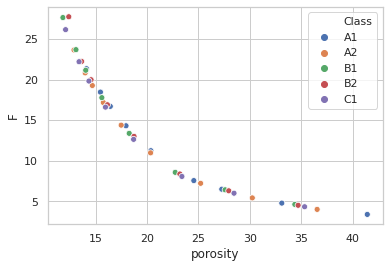

In [4]:
sns.scatterplot('porosity', 'F', hue='Class', data=df)

In [5]:
df.porosity.min()

11.81

Everything looks fairly homoskedastic, so let's try a normal error term 

# Heirarchical model from the classes

In [6]:
model_code_classy_mu_phi = """
data {
    int<lower=1> N;
    int<lower=1,upper=5> rock_class[N];
    vector[N] phi;
    vector[N] F;
}
parameters {
    real <lower=0, upper=11.8> phi_te[5]; // Everything goes to hell if phi_te is greater than any value of phi
    real <lower=0, upper=1e4> C_F[5];
    real <lower=1e-9> mu[5];
    real <lower=0> sigma_e;
}
transformed parameters {
    real mean_F[N];
    for (i in 1:N)
        mean_F[i] = C_F[rock_class[i]] * (phi[i] - phi_te[rock_class[i]]) ^ (-mu[rock_class[i]]);
}
model {
    phi_te ~ cauchy(3,3);
    mu ~ normal(1.5,1);
    C_F ~ lognormal(7,1);
    F ~ normal(mean_F, sigma_e);
}
generated quantities {
    vector[N] log_lik;
    vector[N] F_hat;
    for (i in 1:N) {
        log_lik[i] = normal_lpdf(F[i] | mean_F[i], sigma_e);
        F_hat[i] = normal_rng(mean_F[i], sigma_e);
    }
}
"""
model_classy_mu_phi = pystan.StanModel(model_code=model_code_classy_mu_phi)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94e378743fd216f73e48ad1b2b4f32fc NOW.


In [7]:
data = {'N': len(df.phi), 'phi':df.porosity, 'F':df.F, 'rock_class':df.Class.astype('category').cat.codes + 1}
fit_classy_mu_phi = model_classy_mu_phi.sampling(
    data=data, iter=6000, chains=4, warmup=1000, thin=1, seed=42, pars=['phi_te', 'C_F', 'mu', 'sigma_e','log_lik','F_hat']
)
fit_classy_mu_phi


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_94e378743fd216f73e48ad1b2b4f32fc.
4 chains, each with iter=6000; warmup=1000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%     75%   97.5%  n_eff   Rhat
phi_te[1]     1.75    0.01    1.1    0.1   0.87   1.64     2.5    4.11   9777    1.0
phi_te[2]     1.22  9.3e-3   0.88   0.05    0.5   1.08    1.77    3.24   8886    1.0
phi_te[3]     0.92  7.5e-3    0.7   0.03   0.36   0.77    1.33     2.6   8675    1.0
phi_te[4]      2.7    0.01   1.13   0.43   1.92   2.73    3.48    4.88   9674    1.0
phi_te[5]     1.14  8.9e-3   0.82   0.05   0.48    1.0    1.64    3.03   8481    1.0
C_F[1]      1400.4    5.56 530.62 551.23 983.37 1338.0  1773.7  2492.5   9112    1.0
C_F[2]      1298.3    4.11 398.27 580.76 996.11 1292.7  1598.4  2046.2   9383    1.0
C_F[3]      1390.7    3.76 358.16 684.66 1126.9 1409.8  1663.4  2022.5   9093    1.0
C_F[4

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:86: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f910c7ed430>,
      dtype=object)

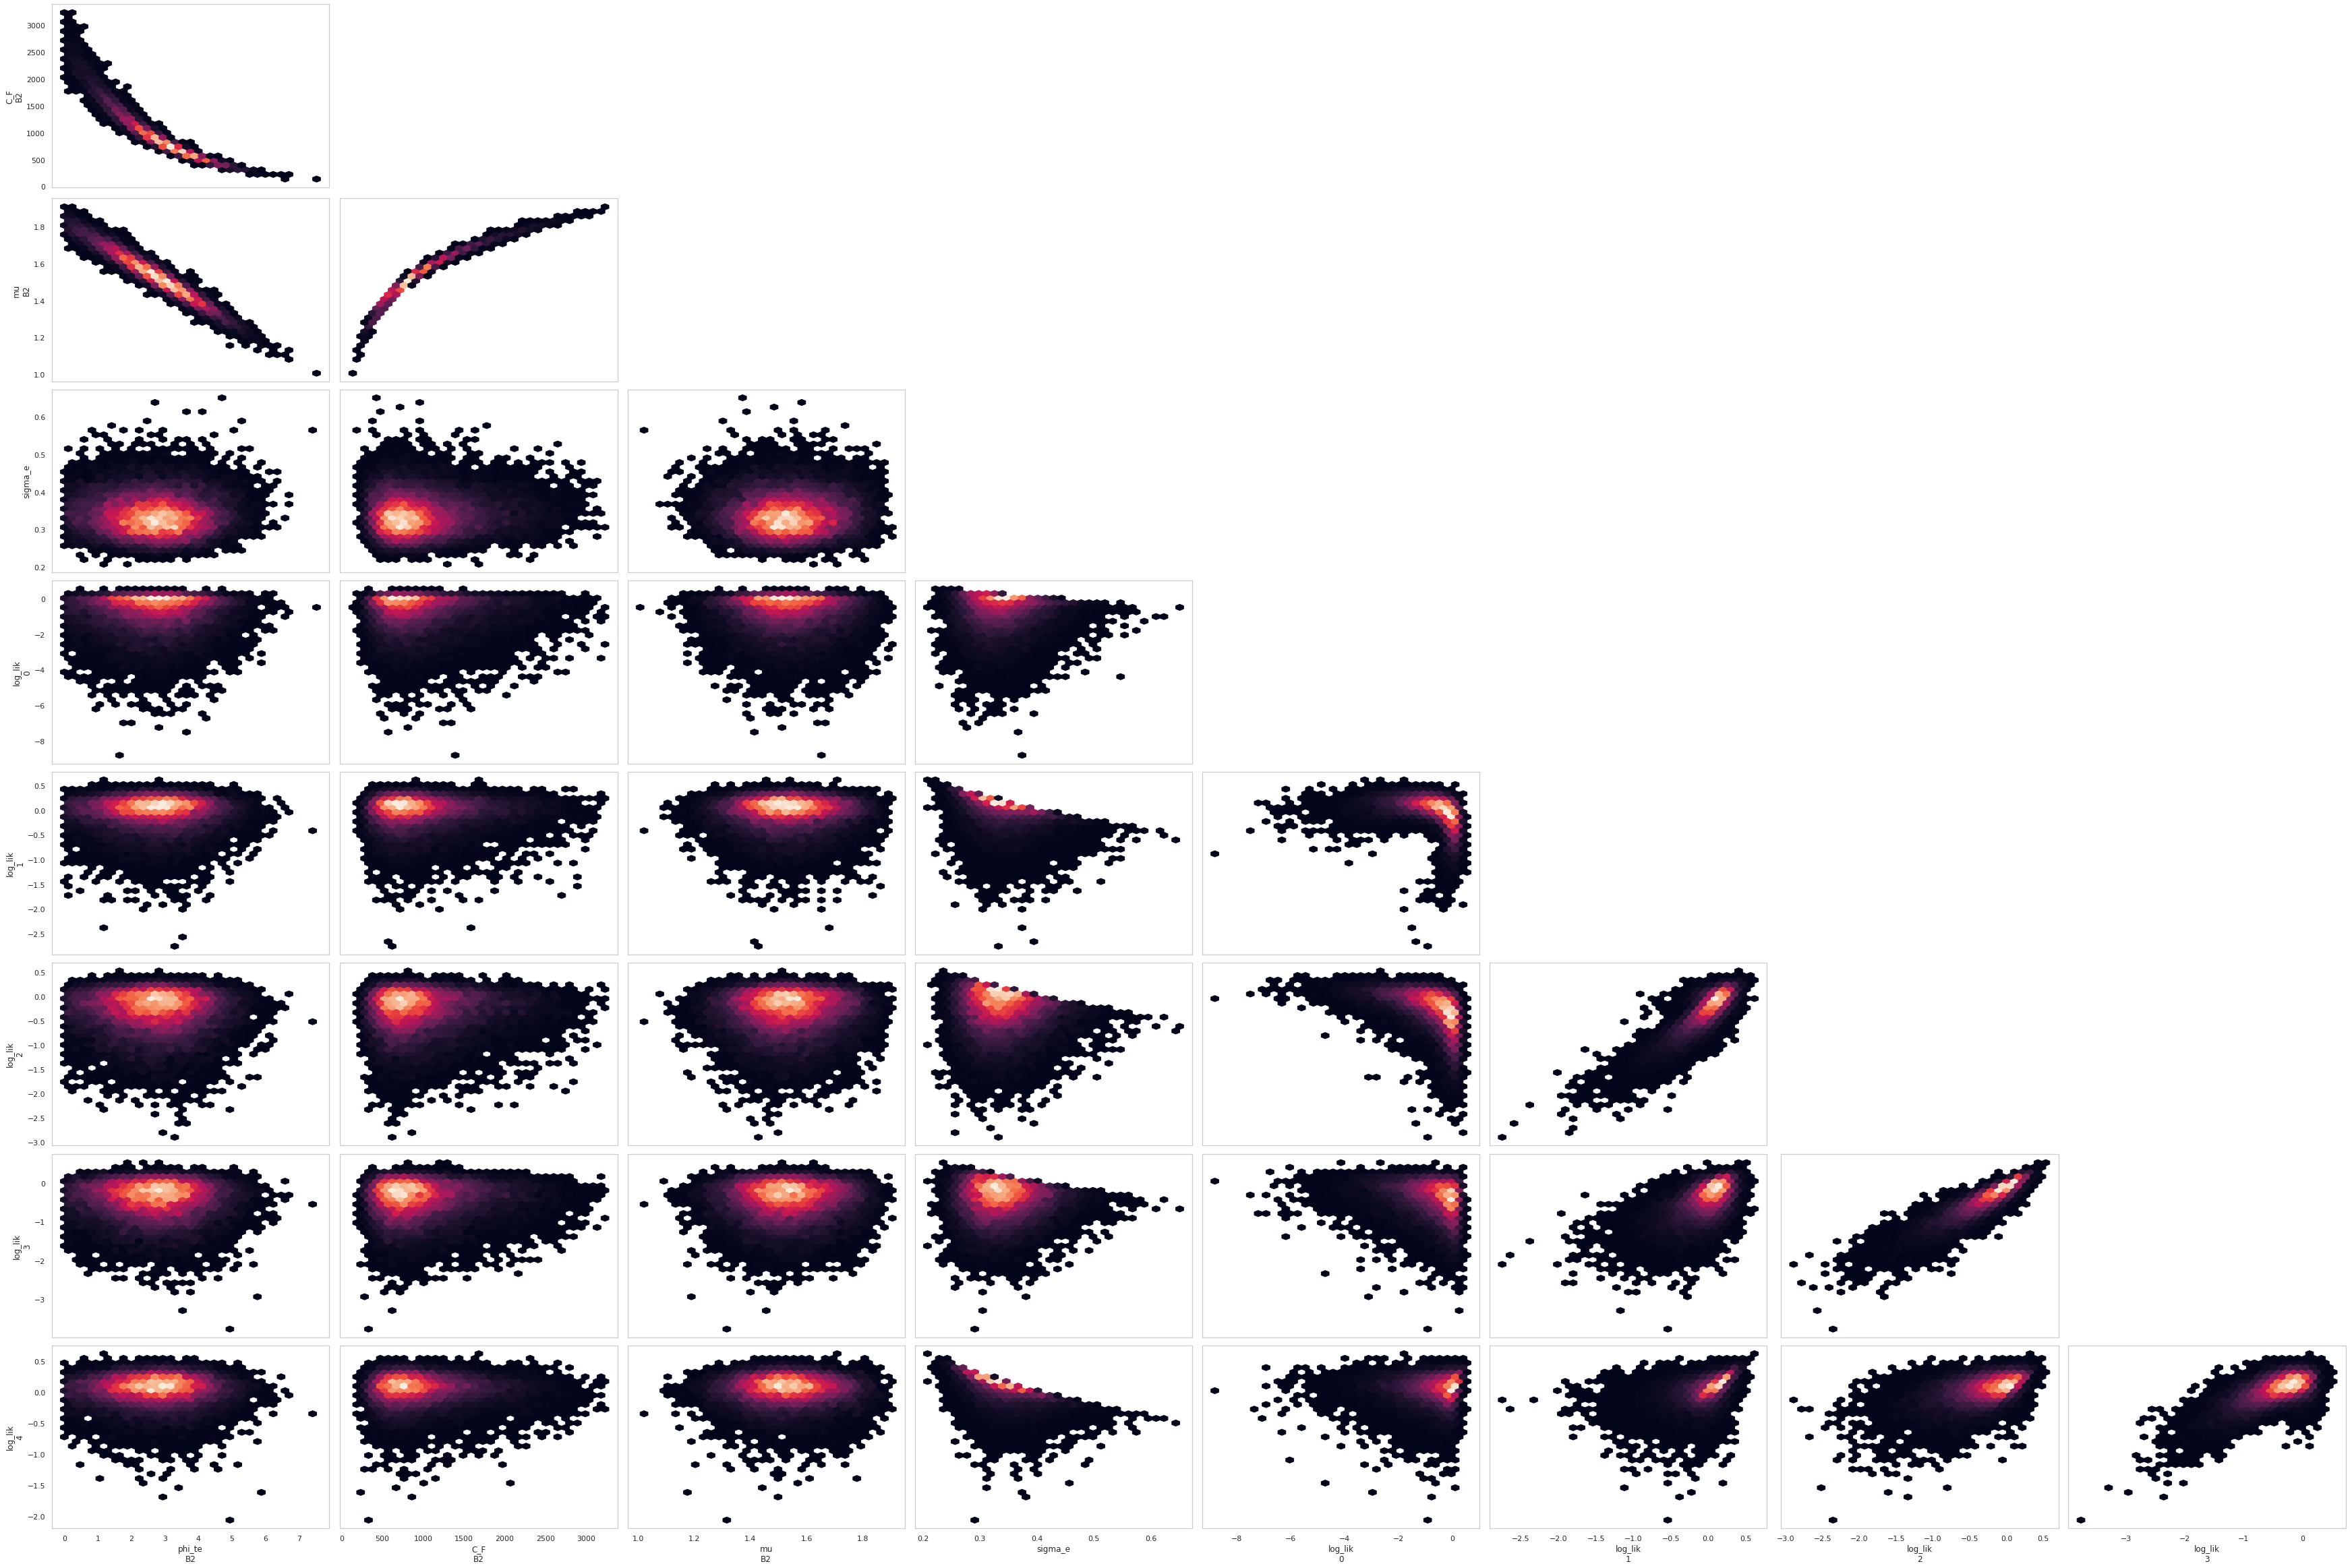

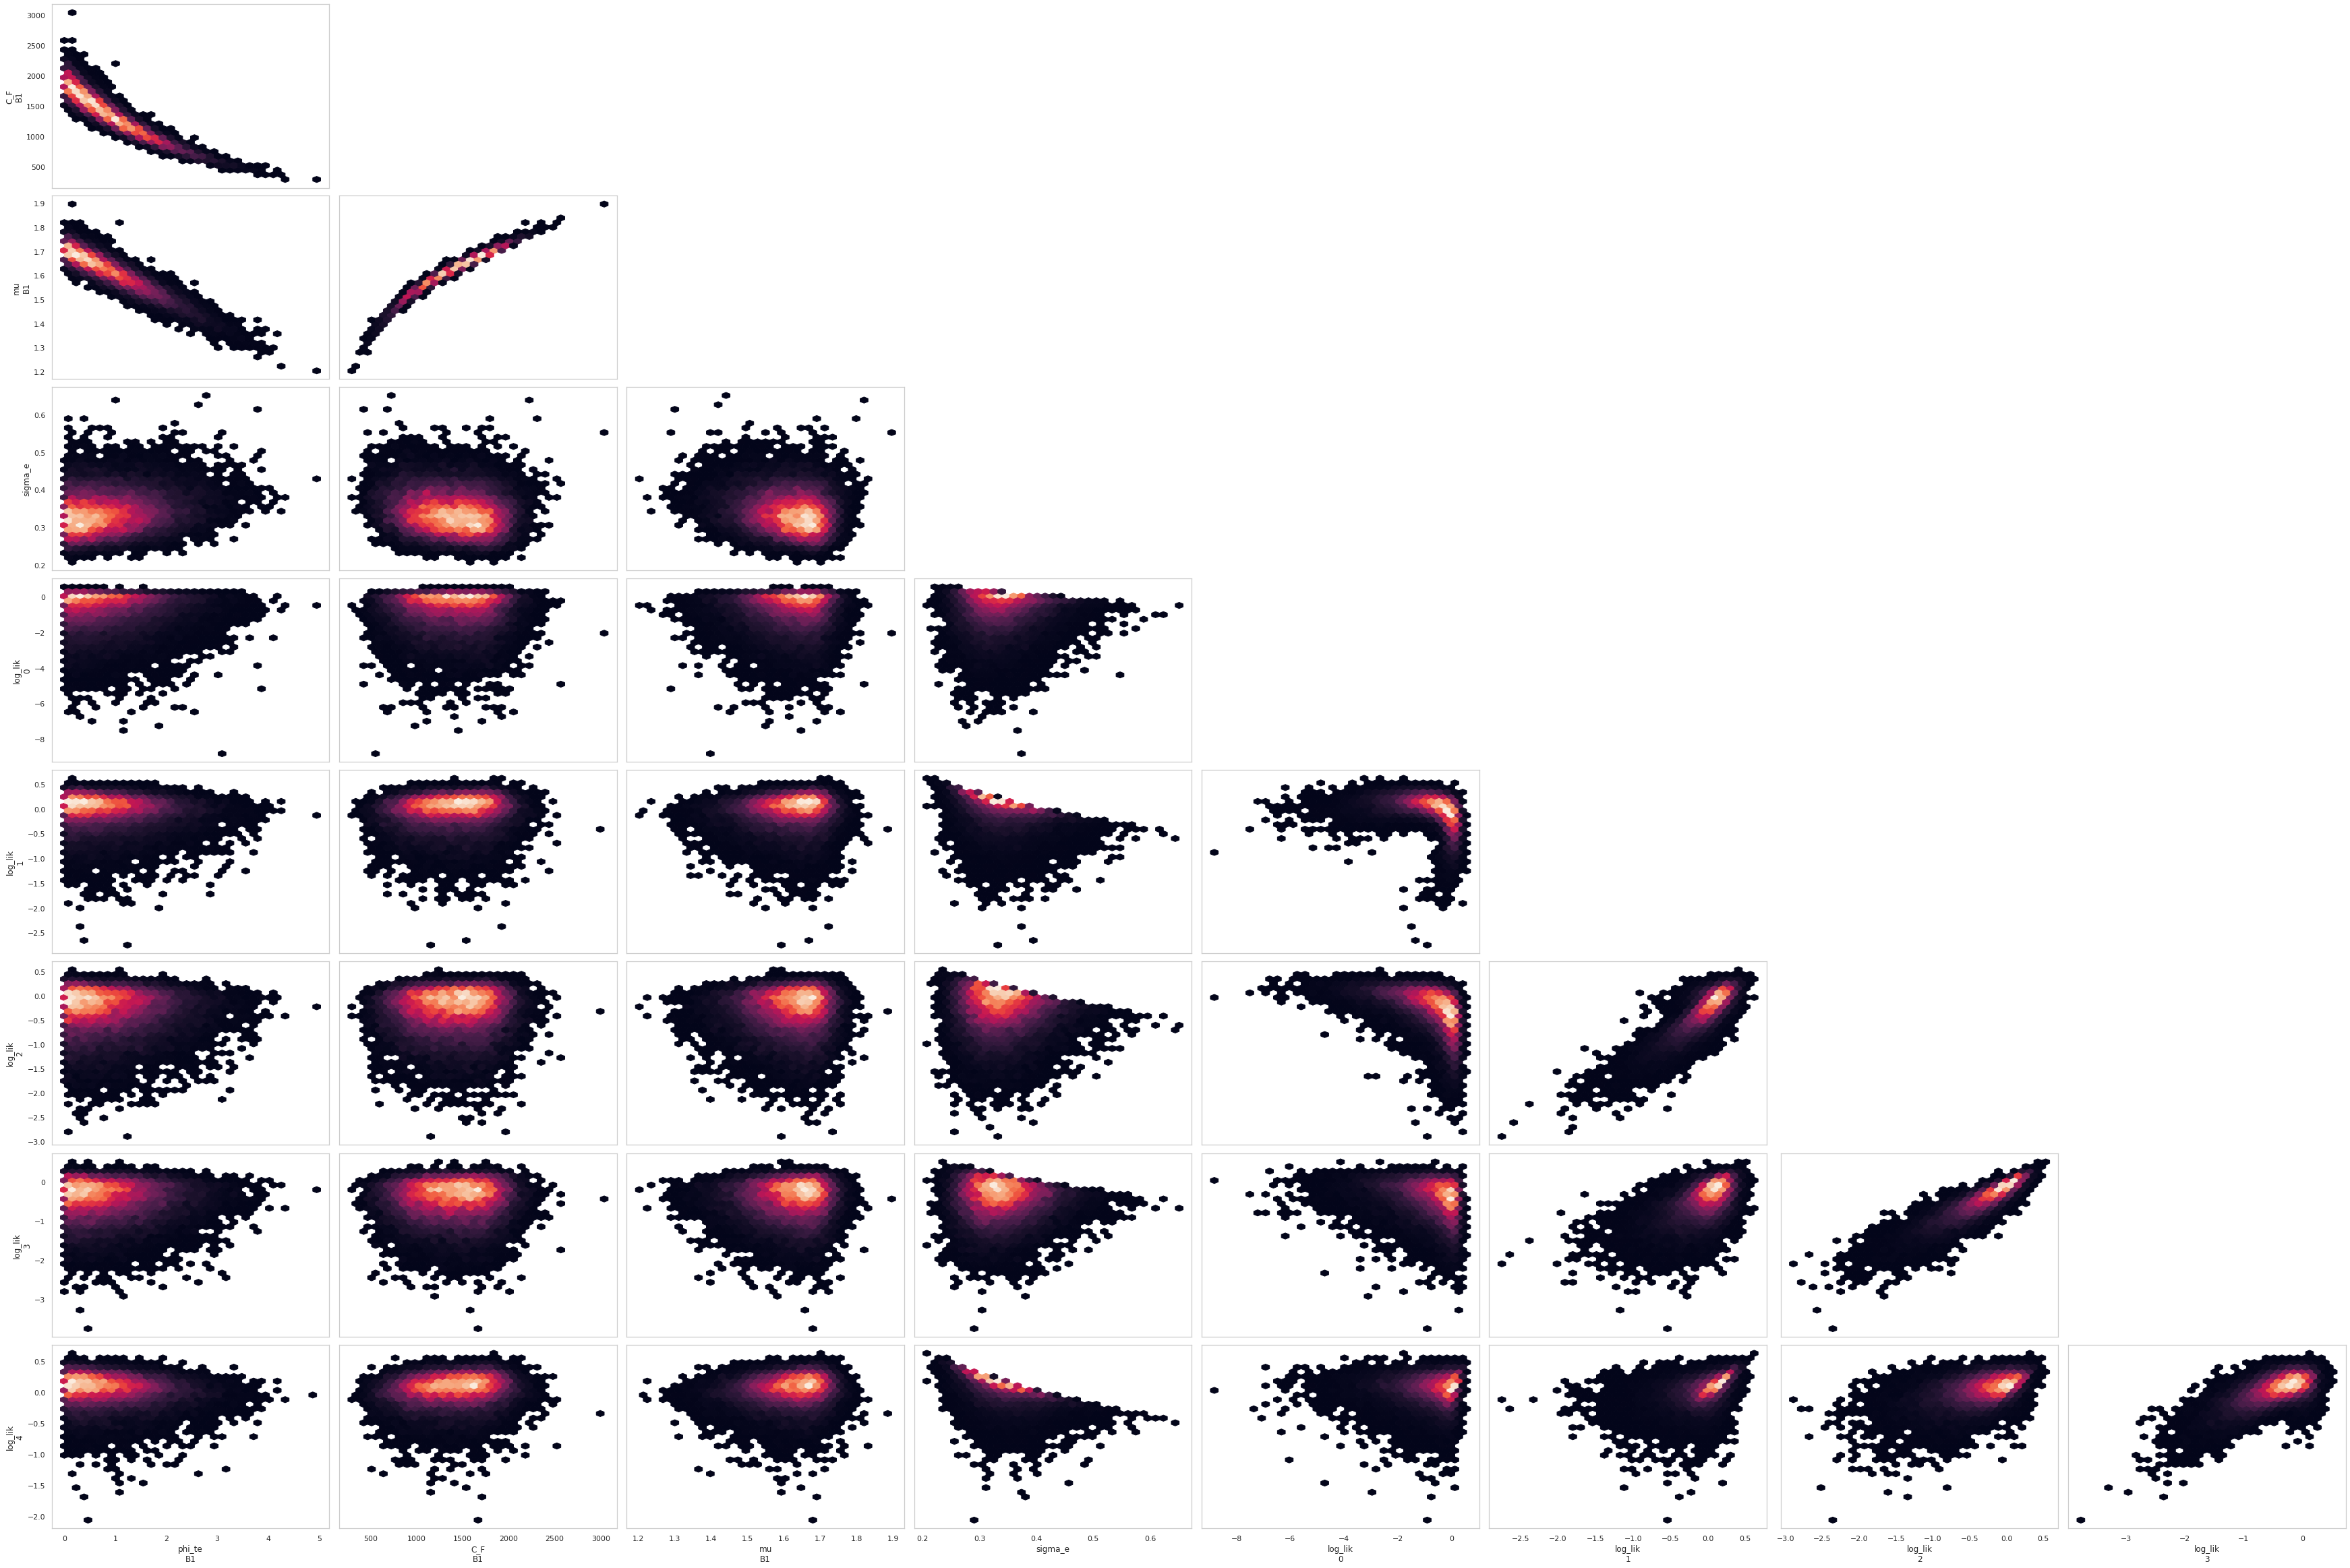

In [8]:
fit_classy_mu_phi_az = az.from_pystan(
    fit_classy_mu_phi, 
    #posterior_predictive='F_hat',
    observed_data=["F"], 
    #log_likelihood = "log_lik",
    coords={"Class": df.Class.unique()}, 
    dims = {"phi_te": ["Class"], "C_F":["Class"], "mu":["Class"]}
)
az.plot_pair(
    fit_classy_mu_phi_az,
    coords={"Class":["B2"]},
    kind="hexbin",
)

az.plot_pair(
    fit_classy_mu_phi_az,
    coords={"Class":["B1"]},
    kind="hexbin",
)

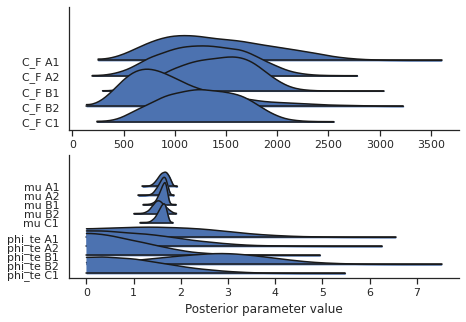

In [23]:
with sns.axes_style('ticks'):
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(7,5))
    az.plot_forest(
        fit_classy_mu_phi_az, var_names=['C_F'], ax=ax1, kind='ridgeplot', combined=True, credible_interval=0.95
    )
    az.plot_forest(fit_classy_mu_phi_az, var_names=['mu', 'phi_te'], ax=ax2, kind='ridgeplot', combined=True)
    ax1.set(xscale='linear', title='')
    ax2.set(xlabel='Posterior parameter value')
    sns.despine()
    plt.savefig('bayes_figures/formation_factor_posterior_distributions.png', bbox_inches='tight', dpi=300)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90fff1f850>],
      dtype=object)

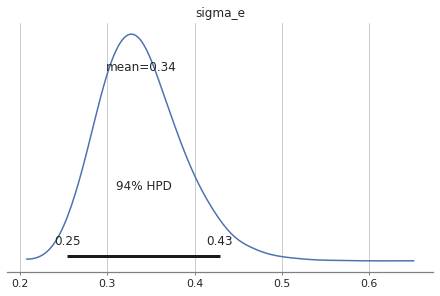

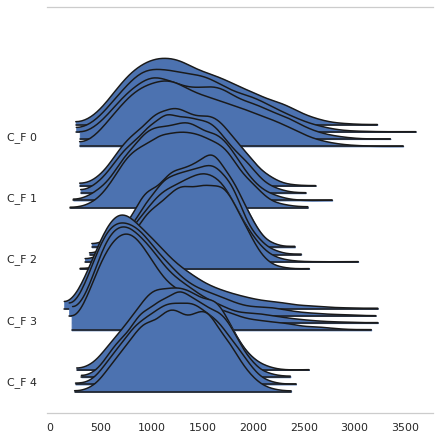

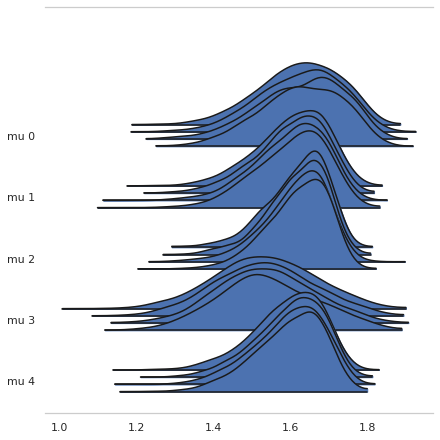

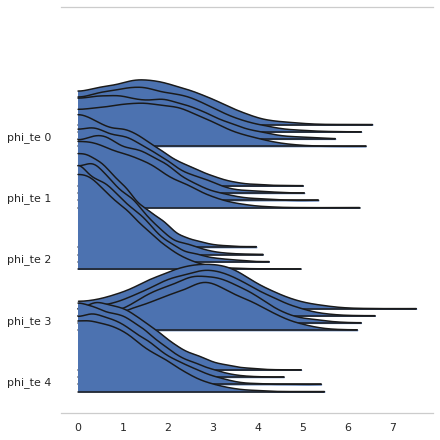

In [10]:
az.plot_posterior(fit_classy_mu_phi, var_names=['sigma_e']) #figsize=(10,10))
az.plot_forest(fit_classy_mu_phi, var_names=['C_F'], kind='ridgeplot')
az.plot_forest(fit_classy_mu_phi, var_names=['mu'], kind='ridgeplot')
az.plot_forest(fit_classy_mu_phi, var_names=['phi_te'], kind='ridgeplot')

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:86: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90ff342d60>,
      dtype=object)

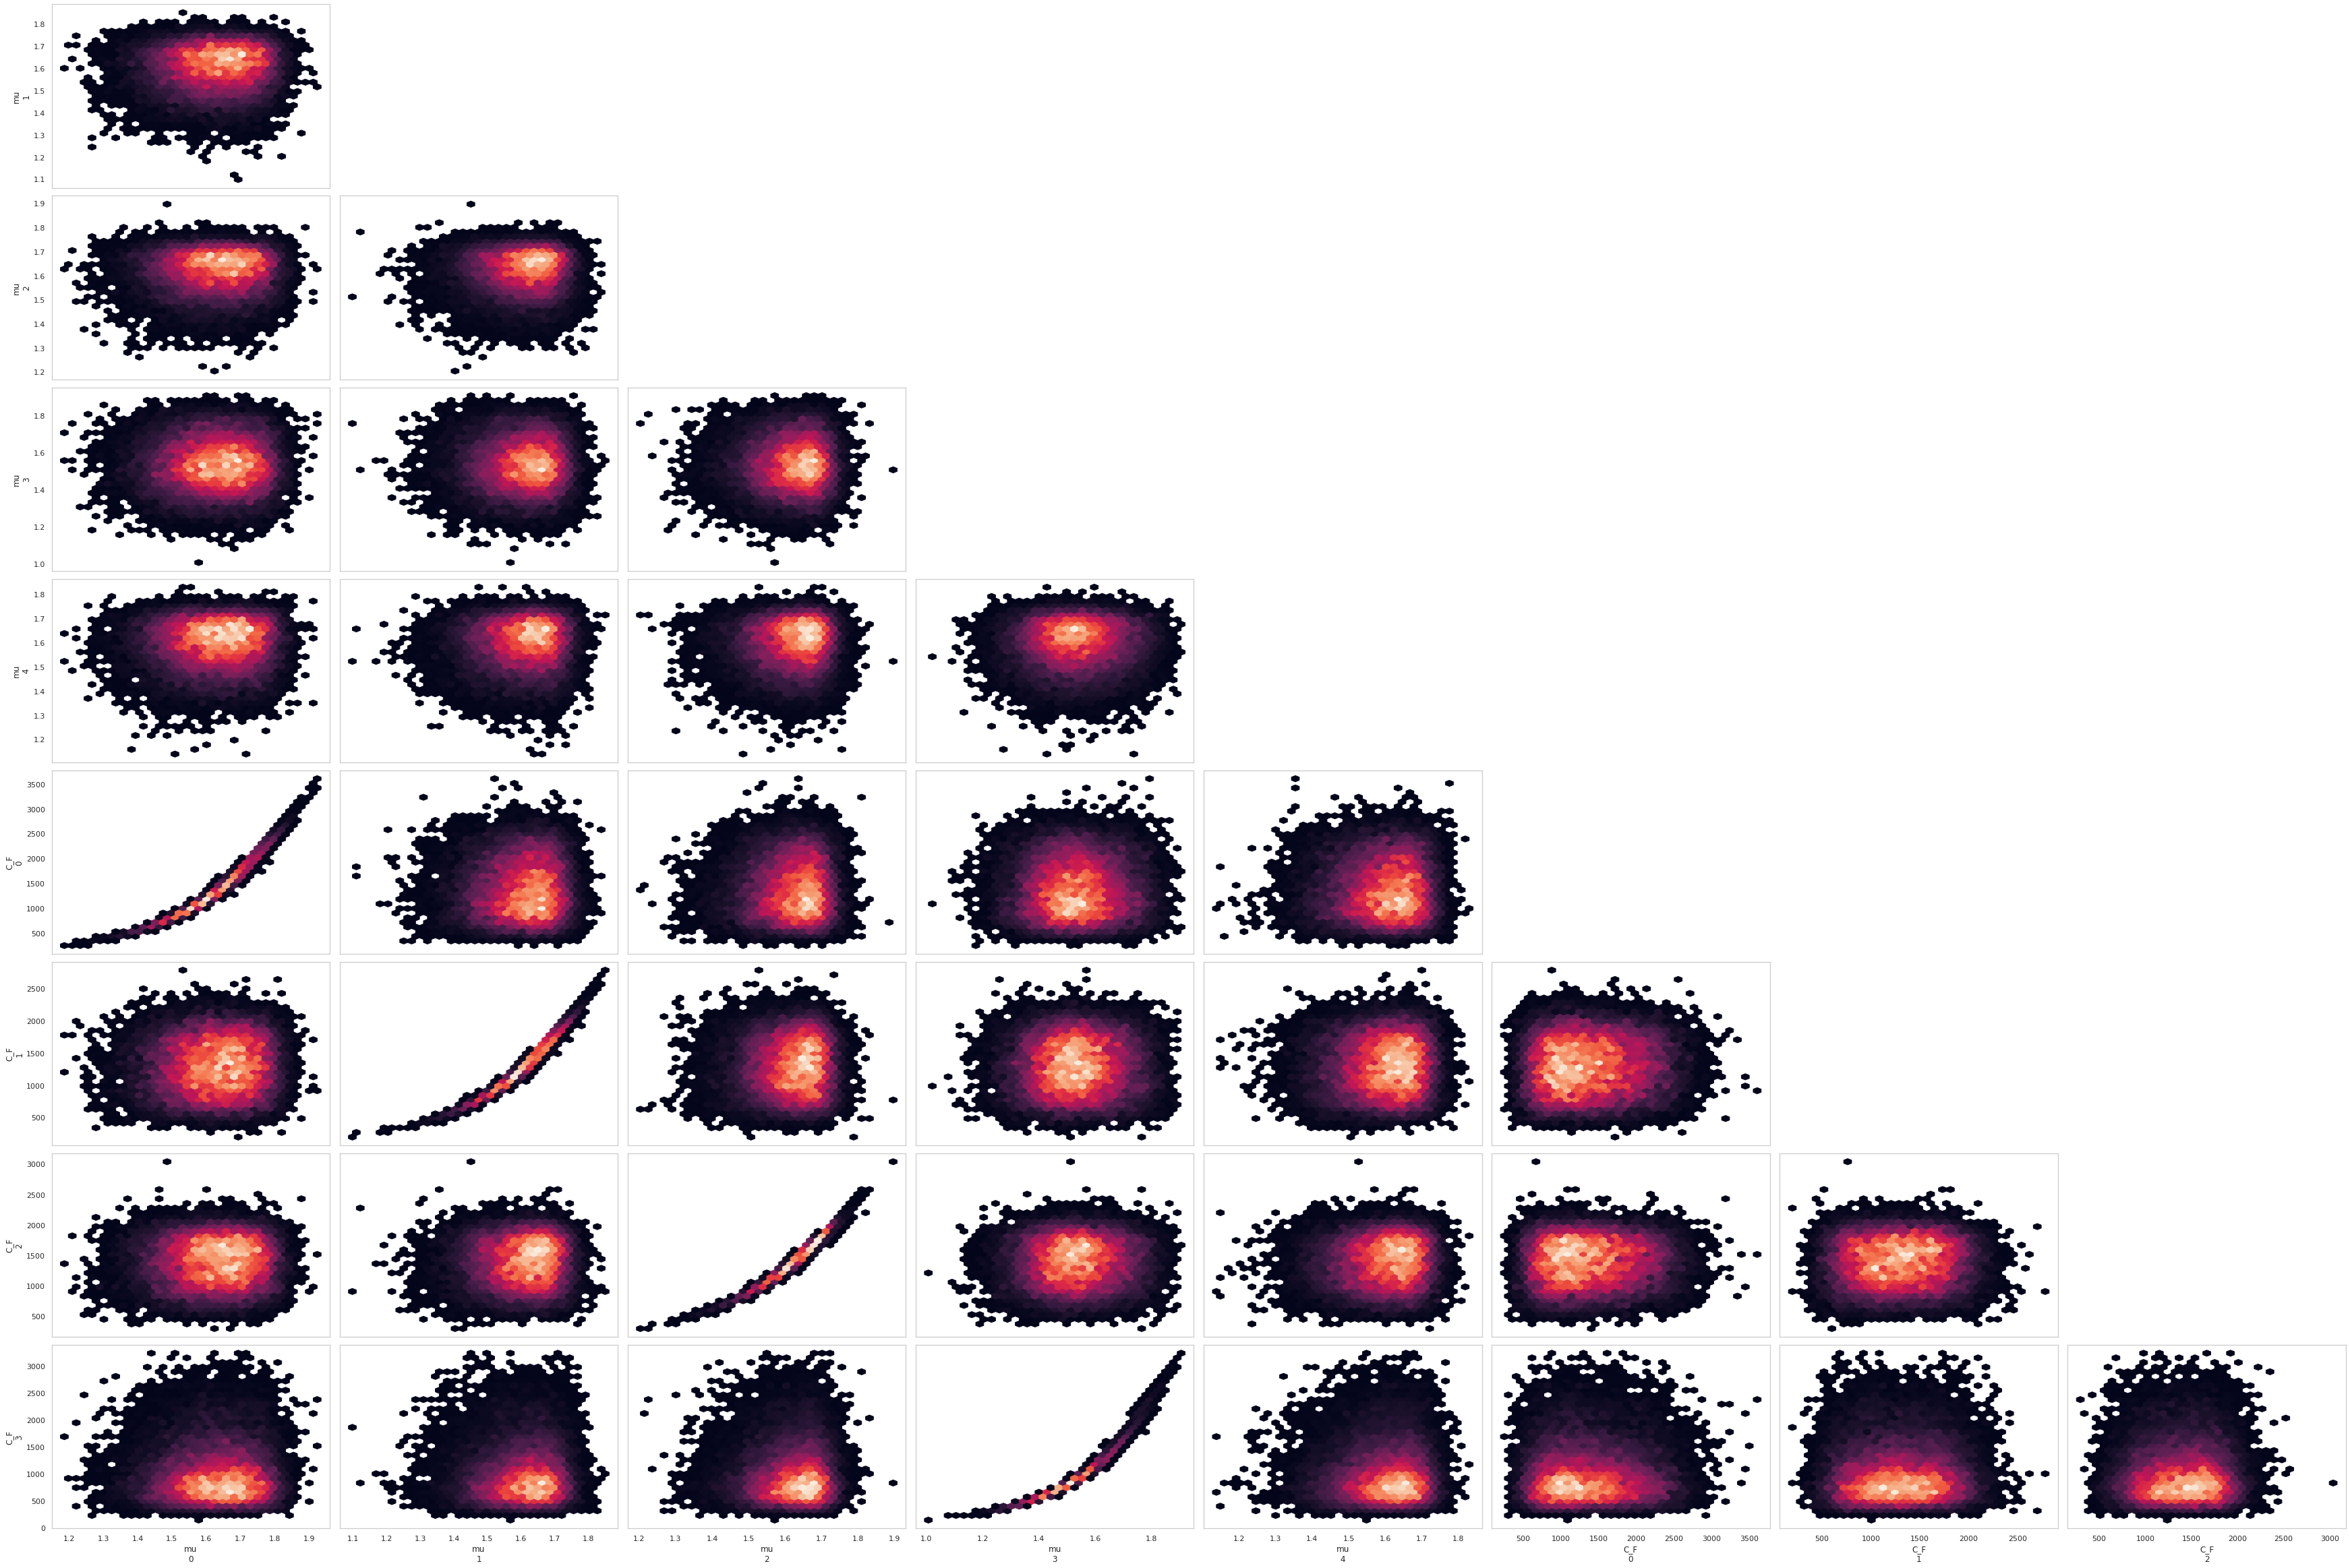

In [11]:
az.plot_pair(fit_classy_mu_phi, var_names=["mu", "C_F"], kind="hexbin")[-1]

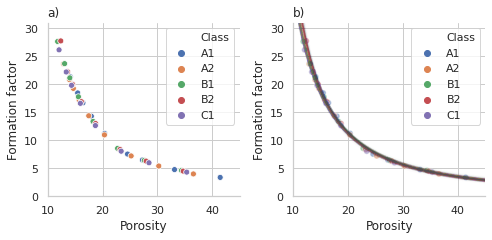

In [12]:
def posterior_examples(phi_predict, fit, class_number=1, num_examples=100):
    mu = fit['mu']
    phi_te = fit['phi_te']
    C_F = fit['C_F']
    samples = np.random.choice(len(mu), num_examples)
    for e in samples:
        yield C_F[e, class_number] * (phi_predict - phi_te[e, class_number]) ** -mu[e, class_number]

phi_pred = np.linspace(11, 45)
pal = sns.color_palette()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3.5))
for class_number in range(5):
    for y in posterior_examples(phi_pred, fit_classy_mu_phi, class_number, 100):
        ax2.plot(phi_pred, y, color=pal[class_number], alpha=.008)
#ax = plt.gca()
sns.scatterplot('porosity', 'F', hue='Class', data=df, ax=ax2, alpha=.5)
sns.scatterplot('porosity', 'F', hue='Class', data=df, ax=ax1)
ax_params = dict(
    xlabel='Porosity',
    xlim=(10, 45),
    ylabel='Formation factor',
    ylim=(0, 31)
)
ax1.set(**ax_params)
ax1.set_title('a)', loc='left')
ax2.set(**ax_params)
ax2.set_title('b)', loc='left')
sns.despine()
fig.tight_layout()
fig.savefig('bayes_figures/formation_factor_fit.png', dpi=300, bbox_inches='tight')

# Single model for everything

In [13]:
model_code = """
data {
    int<lower=1> N;
    vector[N] phi;
    vector[N] F;
}
parameters {
    real <lower=0, upper=11.8> phi_te; // Everything goes to hell if phi_te is greater than any value of phi
    real <lower=0, upper=1e8> C_F;
    real <lower=1e-3> mu;
    real <lower=0> sigma_e;
}
transformed parameters {
    real mean_F[N];
    for (i in 1:N)
        mean_F[i] = C_F * (phi[i] - phi_te) ^ (-mu);
}
model {
    phi_te ~ cauchy(3,3);
    mu ~ normal(1.5,1);
    C_F ~ lognormal(7,1);
    F ~ normal(mean_F, sigma_e);
}
generated quantities {
    vector[N] log_lik;
    vector[N] F_hat;
    for (i in 1:N) {
        log_lik[i] = normal_lpdf(F[i] | mean_F[i], sigma_e);
        F_hat[i] = normal_rng(mean_F[i], sigma_e);
    }
}
"""
model = pystan.StanModel(model_code=model_code, model_name="Composite_formation_factor")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Composite_formation_factor_171b142084cf909dd1d5679d3b030d7a NOW.


In [14]:
data = {'N': len(df.phi), 'phi':df.porosity, 'F':df.F}
fit = model.sampling(
    data=data, iter=4000, chains=4, warmup=1500, thin=1, seed=42,
)

az_fit = az.from_pystan(
    fit,
    posterior_predictive='F_hat',
    observed_data=["F"], 
    log_likelihood = "log_lik",
    #coords={"Class": ["Low porosity", "High porosity"]}, 
    #dims = {"phi_critical": ["Class"], "C_k":["Class"], "t_exponent":["Class"]}
)

az.summary(az_fit, ['phi_te','C_F','mu', 'sigma_e'])

mean       sd    hpd_3%   hpd_97%  mcse_mean  mcse_sd  ess_mean  \
phi_te      0.665    0.538     0.000     1.652      0.014    0.010    1533.0   
C_F      1599.421  317.058  1005.548  2142.632      7.750    5.481    1674.0   
mu          1.663    0.059     1.547     1.757      0.001    0.001    1624.0   
sigma_e     0.503    0.060     0.395     0.617      0.001    0.001    3172.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
phi_te   1444.0    1553.0    2123.0    1.0  
C_F      1674.0    1756.0    1982.0    1.0  
mu       1624.0    1837.0    1971.0    1.0  
sigma_e  3089.0    3306.0    2972.0    1.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90fc435df0>],
      dtype=object)

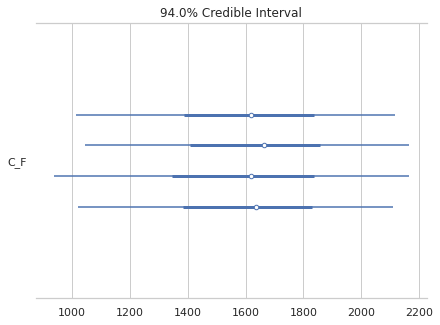

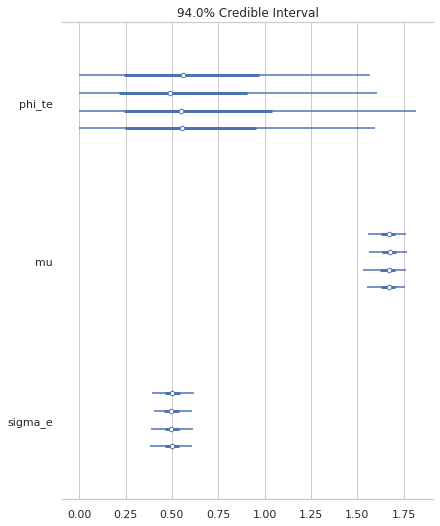

In [24]:
az.plot_forest(az_fit, var_names=['C_F'])
az.plot_forest(az_fit, var_names=['phi_te','mu', 'sigma_e'])

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backend

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90fce9b3a0>,
      dtype=object)

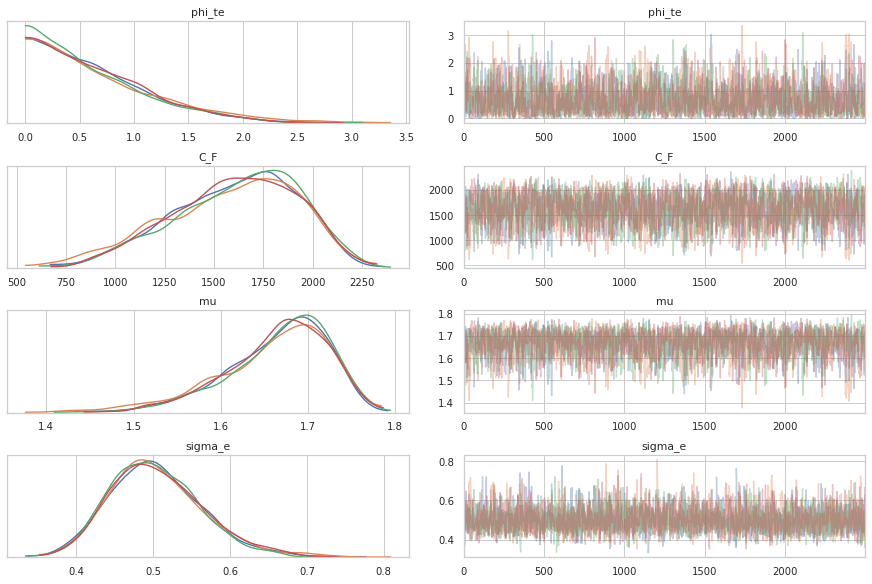

In [16]:
az.plot_trace(az_fit, var_names=['phi_te','C_F','mu', 'sigma_e'])

[Text(0, 0.5, 'Formation factor'), Text(0.5, 0, 'Porosity')]

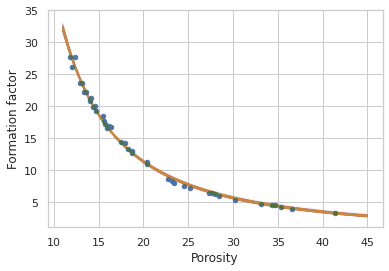

In [17]:
def posterior_examples(phi_predict, fit, num_examples=100):
    mu = fit['mu']
    phi_te = fit['phi_te']
    C_F = fit['C_F']
    samples = np.random.choice(len(mu), num_examples)
    for e in samples:
        yield C_F[e] * (phi_predict - phi_te[e]) ** -mu[e]


phi_pred = np.linspace(11, 45)
for y in posterior_examples(phi_pred, fit, 1000):
    plt.plot(phi_pred, y, color='peru', alpha=.005)
ax = plt.gca()
sc = df.plot.scatter('porosity', 'F', ax=ax)

ax.set(
    xlabel='Porosity',
    #xscale='log',
    ylabel='Formation factor',
    #yscale='log', 
    #ylim=(1e-2, 2e4)
)
#plt.legend()
#plt.xticks([3,5,10,20,30],[3,5,10,20,30]);

It's interesting how well things match for the different classes, but I'm not sure what a negative $\phi_{te}$ means

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9112be58b0>,
      dtype=object)

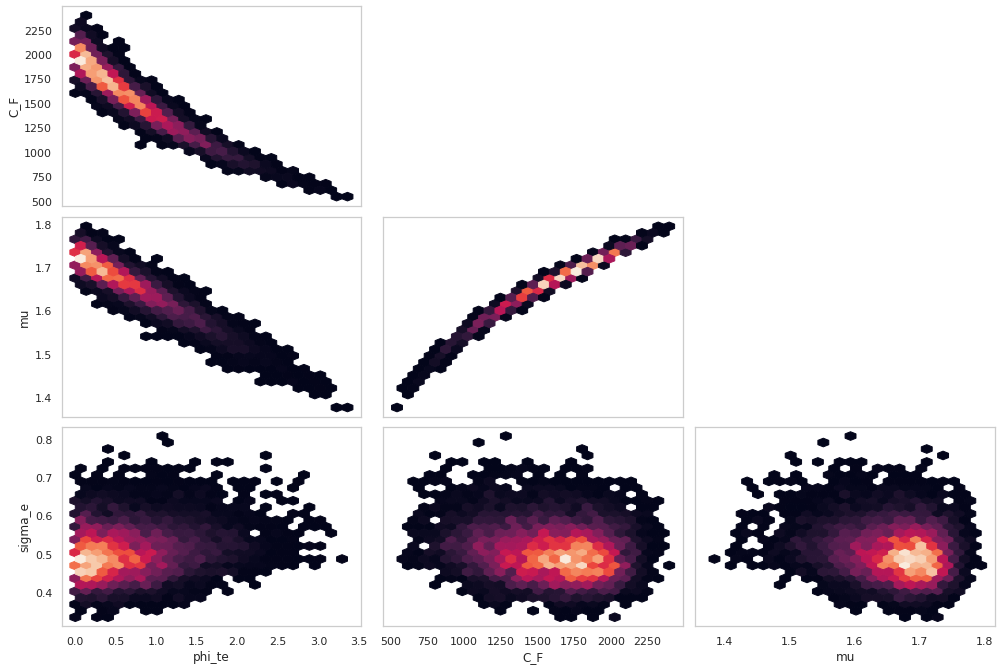

In [18]:
az.plot_pair(az_fit, var_names=['phi_te','C_F','mu', 'sigma_e'], kind="hexbin")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f90fccbd850>,
      dtype=object)

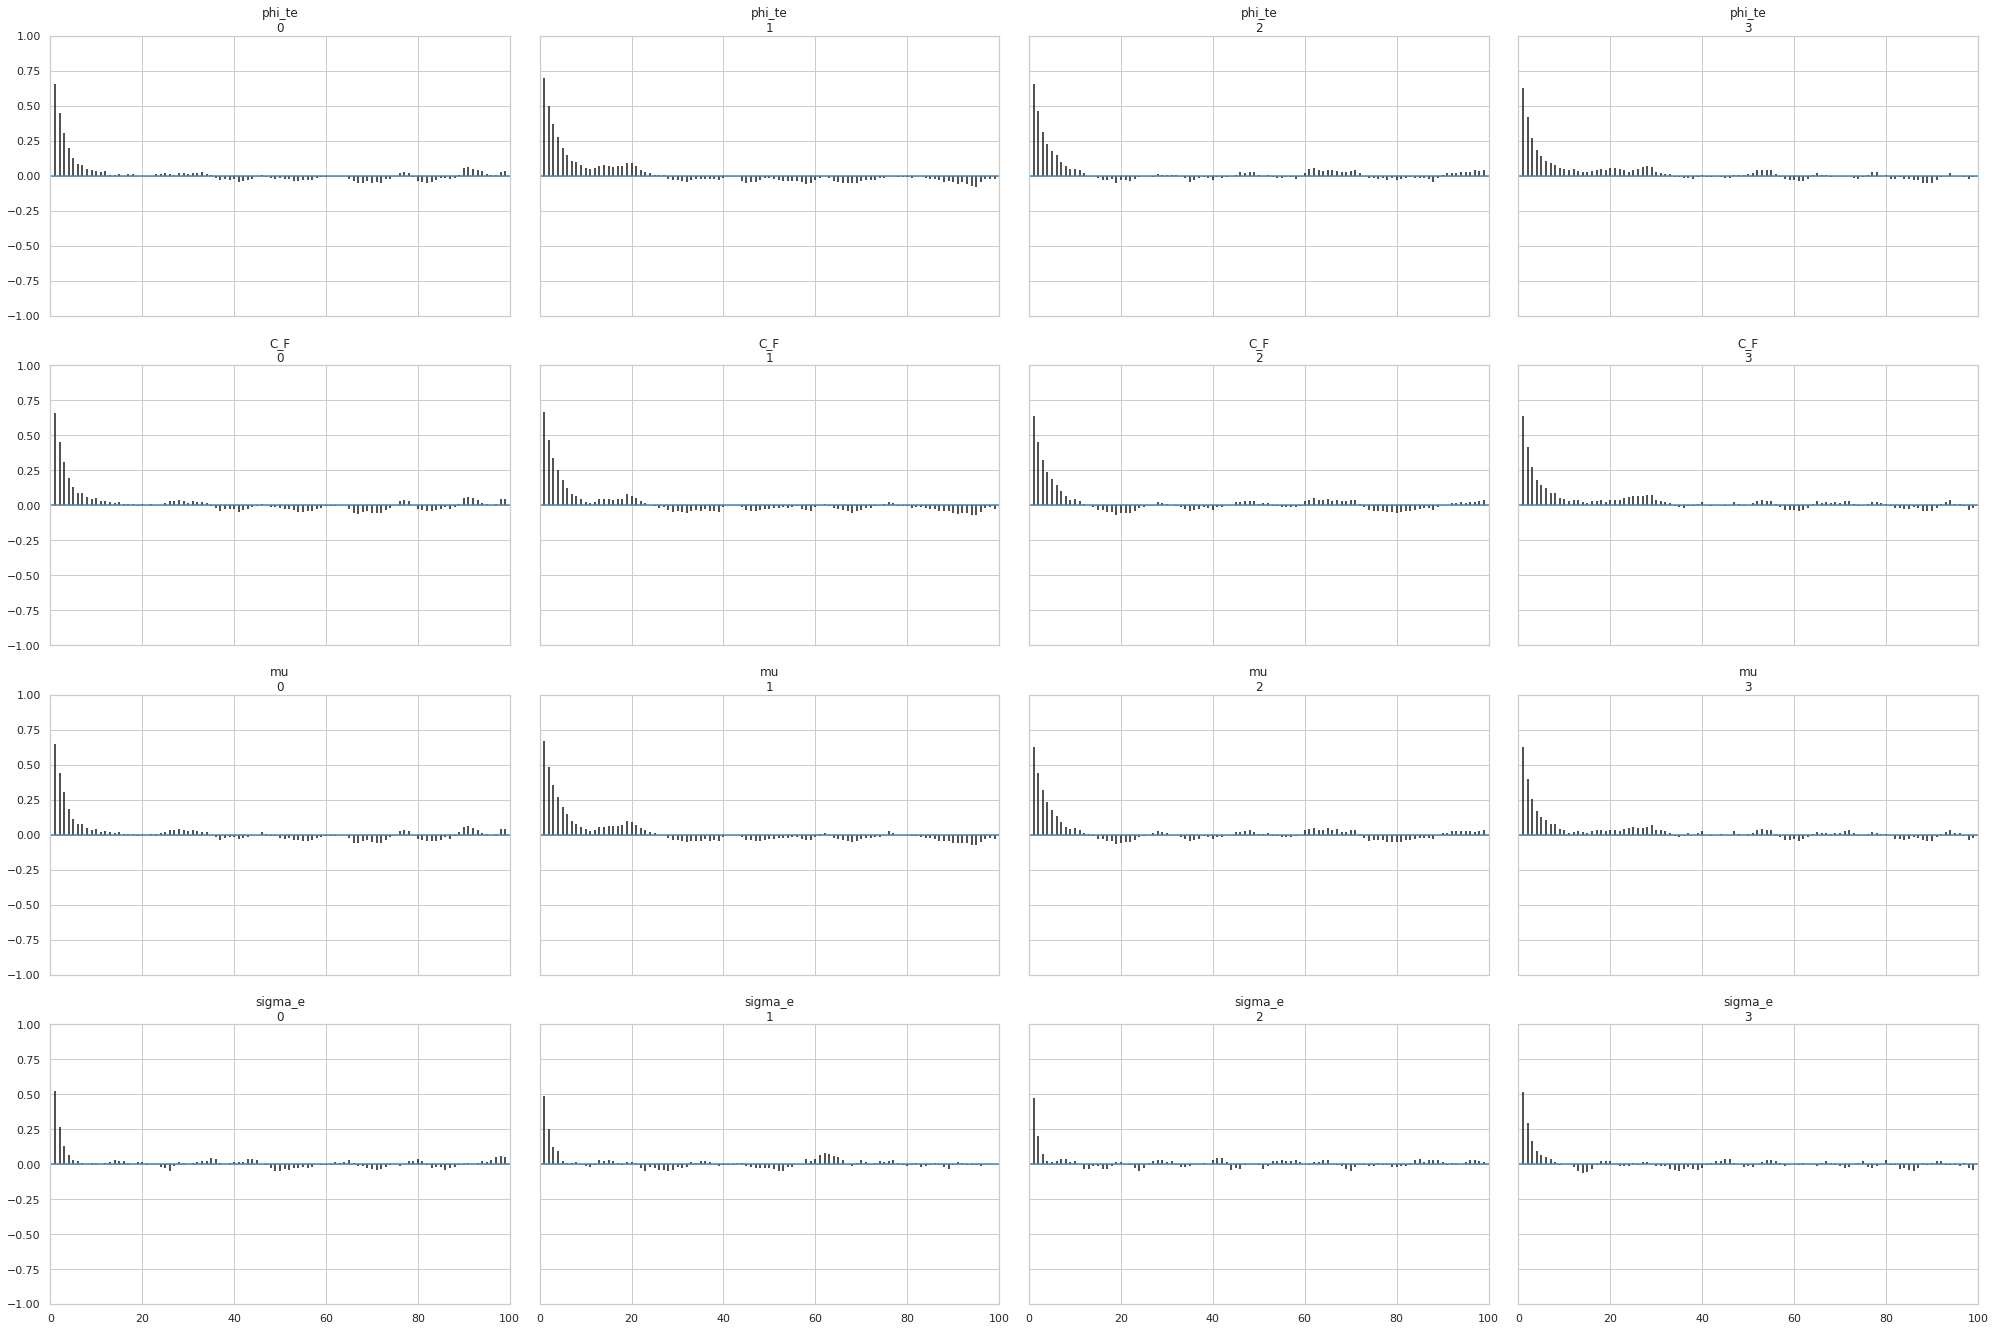

In [19]:
az.plot_autocorr(az_fit, var_names=['phi_te','C_F','mu', 'sigma_e'])